<a href="https://colab.research.google.com/github/saranticha/AI-predict-Breast-Cancer-from-tissue-sample/blob/main/Copy_of_Progetto_Cancro_Seno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prevedere se un cancro al seno è benigno o maligno**

L'obiettivo è quello di allenare un modello classificatore basandosi su un dataset di caratteristiche di cellule cancerose per predire se una data cellula appartiene ad un tumore benigno o maligno.

Il dataset è stato creato dalla University of Wisconsin. Ha preso in esame 569 casi (righe - campioni) e 32 attributi (colonne - caratteristiche).

## **1. Informazioni sul dataset e comprensione**

### Per quale motivo si è scelto di fare un'analisi del genere?




Il cancro al seno è un tipo di tumore che ha inizio nella mammella. Può insorgere in uno o in entrambi i seni. Il tumore al seno può diffondersi quando le cellule cancerose entrano nel sangue o nel sistema linfatico e vengono trasportate in altre parti del corpo. Il sistema linfatico è una parte del sistema immunitario dell'organismo. È una rete di linfonodi (piccole ghiandole della grandezza di un fagiolo), dotti o vasi e organi che lavorano insieme per raccogliere e trasportare il liquido linfatico chiaro attraverso i tessuti del corpo fino al sangue. Il liquido linfatico chiaro all'interno dei vasi linfatici contiene sottoprodotti dei tessuti e materiale di scarto, oltre a cellule del sistema immunitario.

Motivazione: Individuare precocemente il cancro al seno e sottoporsi a un trattamento all'avanguardia sono due delle strategie più importanti per prevenire le morti per cancro al seno. Il cancro al seno trovato precocemente, quando è piccolo e non si è diffuso, è più facile da trattare con successo. In questo lavoro applicheremo una classificazione del cancro al seno con l'algoritmo KNN. Analizzeremo anche gli outlier del dataset prima dell'addestramento KNN. Per aumentare l'accuratezza del modello verranno eseguite tecniche di riduzione delle dimensioni come PCA e NCA.

https://www.kaggle.com/code/emreustundag/breast-cancer-knn-lof-pca-nca

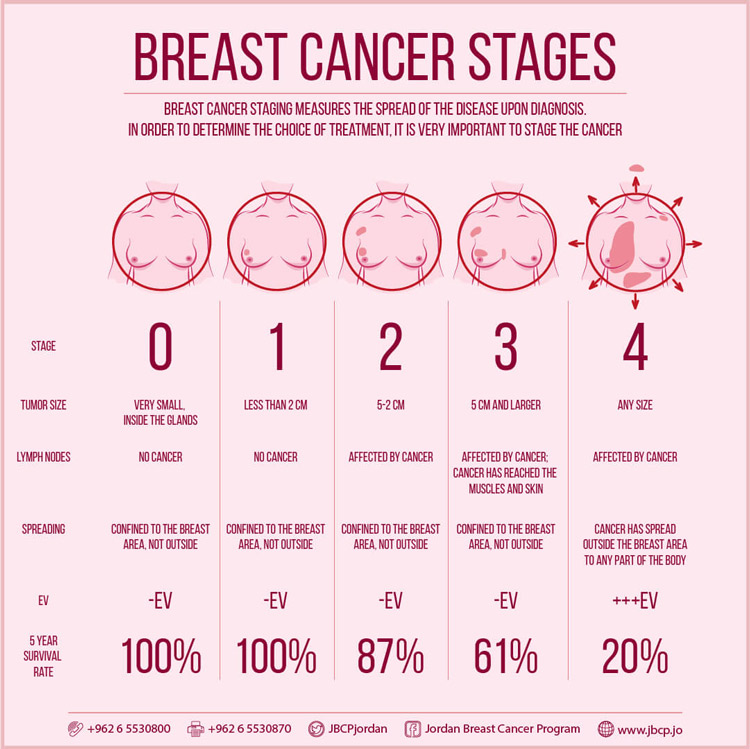

# Dataset

I parametri in esame sono stati ricavati da immagini digitalizzate di campioni di noduli al seno prelevati con agobiopsia. Descrivono le caratteristiche dei nuclei cellulari presenti in ogni immagine.

(Agobiopsia = procedura diagnostica con cui si preleva con un ago sottile un campione di massa sospetta per essere patologica, al fine di analizzarlo al micorscopio in laboratorio)

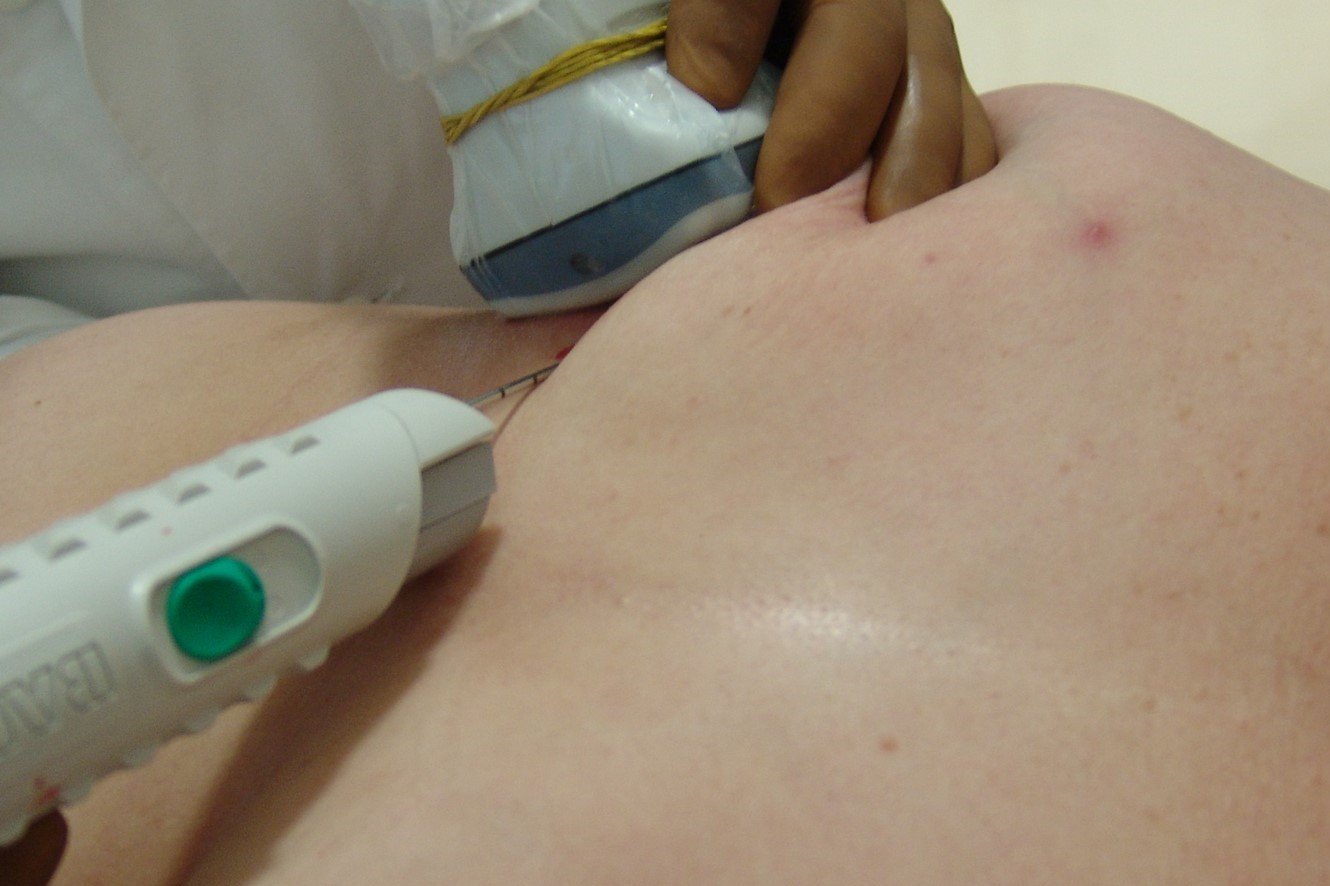

Informazioni sugli attributi del dataset:


1) ID number

2) Diagnosis (M = Malignant; B = Benign)

3-32) Dieci caratteristiche ricavate per ogni nucleo cellulare:
- radius (media delle distanze dei punti del perimetro dal centro);
- texture (deviazione standard dei valori della scala di grigio);
- perimeter;
- area;
- smoothness (variazione locale della lunghezza del raggio);
- compactness (perimetro^2 / area - 1);
- concavity (entità delle porzioni concave del bordo);
- concavity points (numero di porzioni concave del bordo);
- simmetry;
- fractal dimension ("coastline approximation" - 1, è il grado di irregolarità e frammentazione).

Per ogni immagine, sono stati calcolati "mean" (media), "se" (standard error) e "worst" (media dei 3 valori più grandi) di ogni parametro. Il risultato è che sono presenti 30 caratteristiche.
Ad esempio, alla riga n°2 troviamo "radius_mean", alla 12 "radius_se" ed alla 22 "radius_worst".

Ogni attributo è indicato con quattro cifre significative.



## **2. Importare le librerie necessarie**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from urllib.request import urlopen
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, datasets, svm
import graphviz
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV


plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
#warnings.filterwarnings('ignore')


## **3. Caricare il dataset**

Bisogna caricare il file dal proprio PC.

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
'''
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
data = pd.read_csv('data.csv')
'''

"\nimport io\ndata = pd.read_csv(io.BytesIO(uploaded['data.csv']))\ndata = pd.read_csv('data.csv')\n"

In [ ]:
data = pd.read_csv('data.csv')

FileNotFoundError: ignored

In [ ]:
data_violin = data

quest'ultimo comando crea una copia del dataset, che useremo per lavorare sui violin plot

## **4. Osserviamo i dati**

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
data.info()

Ci accorgiamo che esiste una colonna "Unnamed: 32" che contiene valori nulli: andiamo ad eliminarla. Eliminiamo anche la colonna che contiene gli ID dei campioni, non è utile per classificare i dati.

"diagnosis" è la nostra class label, ossia l'attributo di cui vogliamo andare a predire il valore in base agli altri attributi.

Notiamo anche che i restanti dati sono tutti in formato float, ad eccezione della diagnosi, che andiamo a convertire:

In [ ]:
data = data.drop(['Unnamed: 32','id'],axis = 1)
data["diagnosis"] = data["diagnosis"].map({"M":1, "B":0})

In [ ]:
data_save=data

ci salviamo il df pulito in una variabile per poterlo recuperare più tardi e lavorare più facilmente

Stampiamo nuovamente le prime 5 righe (head) per osservare i dati.

In [ ]:
data.head()

Controlliamo se ci sono valori mancanti di cui occuparci:

In [ ]:
def num_missing(x):
  return sum(x.isnull())

print("Missing values per column:")
print(data.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

Stampiamo una tabella con tutti i dati numerici e osserviamo le statistiche sui dati.

In [ ]:
data.describe().T

## **5. Relazioni tra le variabili**

### Scatter plot

È il modo più semplice per studiare la relazione tra variabili.

Osserviamo per esempio se esiste una relazione tra il raggio medio e l'area media.

In [ ]:
data = data_save
plt.figure(figsize = (15,10))
sns.jointplot(data.radius_mean,data.area_mean,kind="reg")
plt.show()

Ovviamente possiamo osservare una correlazione: quando il raggio medio aumenta, aumenta anche l'area media. Perciò c'è una correlazione positiva tra i due.

In [ ]:
plt.figure(figsize = (15,10))
sns.jointplot(data.area_mean,data.fractal_dimension_se,kind="reg")
plt.show()

Al contrario, notiamo che non esiste correlazione tra area media e standard error della dimensione frattale: lo standard error della dimensione frattale non è influenzato dal variare dell'area.

### **Scatter Plot totali**

In [ ]:
#generate a scatter plot matrix with the "mean" columns
cols = ['diagnosis',
        'radius_mean',
        'texture_mean',
        'perimeter_mean',
        'area_mean',
        'smoothness_mean',
        'compactness_mean',
        'concavity_mean',
        'concave points_mean',
        'symmetry_mean',
        'fractal_dimension_mean']

sns.pairplot(data=data[cols], hue='diagnosis', palette='rocket')

Ci sono pattern lineari quasi perfetti tra raggio, perimetro e area. Ciò indicano la presenza di una multicollinearità tra queste variabili (cioè sono strettamente correlate in modo lineare). Un altro set di variabili che potrebbe implicare multicollinearità sono la concavità, i punti di concavità e la compattezza.

La multicollinearità è un problema, poiché potrebbe minare la significatività delle variabili indipendenti. Interveniamo rimuovendo i predittori altamente correlati dal modello.

### **Matrice di correlazione**

Possiamo esaminare la forza delle relazioni tra coppie di variabili.

Osserviamo nella matrice la correlazione tra tutte le caratteristiche a disposizione.
Il range dei numeri ottenibili spazia da 1 (massimo della correlazione positiva tra due variabili) e -1 (massimo della correlazione negativa tra due variabili). Un valore di 0 indica che non esiste correlazione tra le due variabili.

In [ ]:
data.corr()

In [ ]:
f,ax=plt.subplots(figsize = (20,20))
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

Possiamo verificare la presenza della multicollinearità tra alcune delle variabili.
Per esempio, il raggio medio ha una correlazione di 1 e 0.99 con periemtro medio e area media, rispettivamente. Ciò è dato dal fatto che le tre colonne essenzialmente contengono la stessa informazione, che è la dimensione fisica di ciò che stiamo osservando (il nucleo cellulare).

Perciò, selezioneremo soltanto una tra queste tre caratteristiche andando avanti con l'analisi.

Si nota multicollinearità anche tra le colonne "mean" e "worst". Per esempio, il raggio medio ha una correlazione di 0.97 con il raggio worst.

Inoltre, c'è mulicollinearità tra gli attributi: compattezza, concavità e punti di concavità. Quindi potremo selezionare solo uno di questi. Scegliamo la compattezza.

In [ ]:
#First, drop all "worst" columns perchè correlano tutti coi mean
cols = ['radius_worst',
        'texture_worst',
        'perimeter_worst',
        'area_worst',
        'smoothness_worst',
        'compactness_worst',
        'concavity_worst',
        'concave points_worst',
        'symmetry_worst',
        'fractal_dimension_worst']
data = data.drop(cols, axis=1)

#Then, drop all columns related to the "perimeter" and "area" attributes perchè ovviamente sono correlati
cols = ['perimeter_mean',
        'perimeter_se',
        'area_mean',
        'area_se']
data = data.drop(cols, axis=1)

#Lastly, drop all columns related to the "concavity" and "concave points" attributes perchè correlati con un altra che abbimo lasciato
cols = ['concavity_mean',
        'concavity_se',
        'concave points_mean',
        'concave points_se']
data = data.drop(cols, axis=1)

data_final = data
#verify remaining columns
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

In [ ]:
#Draw the heatmap again, with the new correlation matrix
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

## **6. Visualizzazione dei dati**

### **Istogramma 1**

Andiamo ad osservare la numerosità dei tumori benigni B e maligni M nel dataset.

In [ ]:
col = data_violin.columns       #mettiamo in col le colonne del df
y = data_violin.diagnosis        #variabile che contiene i valori della colonna diagnosis
list = ['Unnamed: 32','id','diagnosis']         #array con colonne da eliminare
x = data_violin.drop(list,axis = 1 )   #nuovo df chiamato x contenere tutte le colonne tranne quelle messe in list
ax = sns.countplot(y,label="Count")    #qui con countploot della libreria seaborn creiamo un gafico che mostra il conteggio delle variabili e lo assegniamo ad ax
B, M = y.value_counts()               #con tale funzione conteggiamo e riportiamo nelle variabili B e M i valori di ogni variabile presente
                                    #il risultato sarà in modo che il primo elemento sia quello più frequente. Esclude i valori NA di default.
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

Iniziamo studiando la distribuzione delle variabili nel modo più semplice: l'istogramma ci permette di visualizzare quante volte ogni valore appare nel dataset (frequenza).

Possiamo andare ad osservare in particolare alcuni parametri: nonostante ci sia leggera sovrapposizione, si nota che la maggior parte delle cellule di tumori benigni hanno un raggio (e perciò un'area) minore rispetto a quelle dei tumori maligni. Stesso discorso vale per la concavità.

Andiamo ad osservare con maggiore risoluzione queste distribuzioni:

In [ ]:
lista = ["radius_mean", "texture_mean", 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']


In [ ]:
for i in lista:
  #('radius_mean', 'texture_mean', "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"):
  m = plt.hist(data[data["diagnosis"] == 1][i], bins=30, fc=(1,0,0,0.5), label="Tumori Maligni")
  b = plt.hist(data[data["diagnosis"] == 0][i], bins=30, fc=(0,1,0,0.5), label="Tumori Benigni")
  plt.legend()
  plt.xlabel("Raggio Medio")
  plt.ylabel("Frequenza")
  plt.title("Istogramma del {} del nucleo di cellule tumorali".format(i))
  plt.show()
  frequent_malignant_radius_mean = m[0].max()

Le distribuzioni di raggio e area riguardanti i tumori benigni sono approssimabili ad una normale.

Dai grafici, possiamo notare che il raggio, l'area e la concavità medie dei nuclei di cellule appartenenti a tumori maligni sono tendenzialmente maggiori di quelle nei tumori benigni.

### **Curve**

Andiamo a disegnare le curve per i tre parametri che vogliamo approfondire:

In [ ]:
for i in lista:
  data[i].plot.kde(title = i)
  plt.show()

Possiamo osservare nelle curve una curtosi positiva e un'asimmetria positiva.

(curtosi = allontanamento dalla normalità distributiva, rispetto alla quale si verifica un maggiore appiattimento o un maggiore allungamento. La sua misura più nota è l'indice di Pearson)

Chiaramente ciò è dovuto al fatto che abbiamo meno dati riguardanti i tumori maligni (vedi istogramma 1). Il secondo picco nei grafici di raggio e area è dovuto al fatto che sto osservando contemporaneamente i dati di tumori benigni e maligni, non alla presenza di outliers. Possiamo vederlo meglio andando a separare le due curve:

In [ ]:
for i in lista:
  data[i][data["diagnosis"] == 1].plot.kde(title = i, c = "r")
  data[i][data["diagnosis"] == 0].plot.kde(title = i, c = "g")
  plt.show()

### PCA

**Queste qui sotto sono le celle che si trovano alla fine del capitolo della colineaarità, va spiegato meglio il senso della PCA.**

La multicollinearità è un problema, poiché potrebbe minare la significatività delle variabili indipendenti. Interveniamo rimuovendo i predittori altamente correlati dal modello.

Usiamo la PLS o PCA, metodi di regressione che tagliano il numero di predittori per ottenere un set più piccolo di componenti non correlate.

rivedere quali librerei aggiungere e rimuovere cella sottostante

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
from matplotlib.colors import ListedColormap
#
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
#
import warnings
warnings.filterwarnings("ignore")

avremo bisogno, per la PCA, di un y contenente i valori di diagnosis mentre non devono essere presenti, tali valori, nell'originario dataset.

In [ ]:
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis=1)

In [ ]:
x.head()

In [ ]:
# la PCA ha bisogno della standardizzazione dei dati
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


vogliamo prima valutare la significatività delle prime componenti principali

In [ ]:
pca = PCA(n_components=5)
pca.fit(x_scaled)

# Calcolo dei valori di significatività delle componenti principali
variance_ratio = pca.explained_variance_ratio_

# Visualizzazione dei valori di significatività in un grafico a barre
plt.bar(range(len(variance_ratio)), variance_ratio)
plt.xlabel('Componenti Principali')
plt.ylabel('Percentuale di varianza spiegata')

# Aggiunta dell'etichetta con i valori di significatività nel grafico
for i, val in enumerate(variance_ratio):
    plt.text(i, val, str(round(val*100, 2)) + '%')

plt.show()

Le prime 3 componenti principali spiegano da sole più del 85% della singificatività dei dati.
Possiamo quindi prendere queste tre prime componenti principali e andarle a graficare, ottenendo un grafico scatter plot in 3D.

In [ ]:
# Build PCA
pca = PCA(n_components = 3)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)

pca_data = pd.DataFrame(X_reduced_pca,columns=["p1","p2","p3"])
pca_data["diagnosis"] = y

In [ ]:
hue = pca_data["diagnosis"]
data = [
    go.Scatter3d(
        x=pca_data.p1,
        y=pca_data.p2,
        z=pca_data.p3,
        mode='markers',
        marker=dict(
            size=4,
            color=hue,
            symbol="circle",
            line=dict(width=2)
        )
    )
]

layout = go.Layout(title="PCA",
                   scene=dict(
                       xaxis=dict(title="p1"),
                       yaxis=dict(title="p2"),
                       zaxis=dict(title="p3")
                   ),
                   hovermode="closest")

fig = go.Figure(data=data, layout=layout)

# Add rotation animation
fig.update_layout(scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                                         center=dict(x=0, y=0, z=0),
                                         eye=dict(x=2, y=2, z=0.1))),
                  updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    buttons=[dict(label='Rotate',
                                                  method='animate',
                                                  args=[None,
                                                        dict(frame=dict(duration=50, redraw=True),
                                                             fromcurrent=True,
                                                             transition=dict(duration=0))
                                                       ]
                                                 )
                                            ]
                                   )
                             ])

pyo.iplot(fig)

possiamo vedere chiaramente nel grafico come si distinguino due cluster, con ancora più significatività data dalla terza componente principale. Possiamo comunque apprezzare una significativa divisione in cluster da uno scatter plot in 2D

In [ ]:
data=data_save
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis=1)

# PCA needs scaled data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Build PCA
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)

pca_data = pd.DataFrame(X_reduced_pca,columns=["p1","p2"])
pca_data["diagnosis"] = y
hue =pca_data["diagnosis"]
data = [go.Scatter(x = pca_data.p1,
                   y = pca_data.p2,
                   mode = 'markers',
                   marker=dict(
                           size=12,
                           color=hue,
                           symbol="pentagon",
                           line=dict(width=2)
                           ))]

layout = go.Layout(title="PCA",
                   xaxis=dict(title="p1"),
                   yaxis=dict(title="p2"),
                   hovermode="closest")
fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)

•	La PCA è una tecnica utile quando si ha un set di dati con un grande numero di variabili e si desidera ridurlo a un numero inferiore di variabili senza perdere informazioni importanti. è una tecnica che potrebbe essere utilizzata per ridurre la dimensionalità, ovvero per semplificare la struttura dei dati. In realtà noi abbiamo semplificato i dati non tramite la PCA, ma osservando le correlazioni tra le colonne tramite scatter plot e matrice di correlazione. Quindi come semplice metodo di visualizzazione dei dati.  avremo bisogno, per la PCA, di un y contenente i valori di diagnosis mentre non devono essere presenti, tali valori, nell'originario dataset.   E andiamo a visualizzare che effettivamente sia stato eliminato diagnosis, con la funzione head. Standardizziamo i dati e andiamo a valutare la significatività  delle prime componenti principali. Le prime 3 componenti principali spiegano da sole più del 85% della significatività dei dati. Possiamo quindi prendere queste tre prime componenti principali e andarle a graficare, ottenendo un grafico scatter plot in 3D (scegliamo le prime tre perché ci troviamo in un ambiente tridimensionale)

### **Outliers**

Osservando l'istogramma di distribuzione delle aree medie, ci accorgiamo della presenza di alcuni valori più rari nelle due distribuzioni. Questi valori possono essere dovuti ad errori o eventi rari e vengono chiamati "outlier".

Per calcolare gli outlier bisogna:
- calcolare il primo quartile (Q1)(25%);
- trovare l'IQR (Inter Quartile Range) = Q3 - Q1;
- calcolare Q1 - 1.5 IQR e Q3 + 1.5 IQR;
- ogni valore al di fuori di questo range è un outlier.

In [ ]:
data = data_save

In [ ]:
data_bening = data[data["diagnosis"] == 0]
data_bening.drop('diagnosis', inplace=True, axis=1)
list_column = data_bening.columns

In [ ]:
for element in list_column:
  print(element)
  data_bening = data[data["diagnosis"] == 0]
  desc = data_bening[element].describe()
  Q1 = desc[4]
  Q3 = desc[6]
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  print("Per i tumori benigni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
  data_bening[data_bening[element] < lower_bound][element]
  print("Outliers: ", data_bening[(data_bening[element] < lower_bound) | (data_bening[element] > upper_bound)][element].values)

In [ ]:
'''
data_bening = data[data["diagnosis"] == 0]
desc = data_bening.radius_mean.describe()
Q1 = desc[4]
Q3 = desc[6]
IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print("Per i tumori benigni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
data_bening[data_bening.radius_mean < lower_bound].radius_mean
print("Outliers: ",data_bening[(data_bening.radius_mean < lower_bound) | (data_bening.radius_mean > upper_bound)].radius_mean.values)
'''

In [ ]:
data_malignant = data[data["diagnosis"] == 0]
data_malignant.drop('diagnosis', inplace=True, axis=1)
data_malignant.head()
list_column = data_malignant.columns

In [ ]:
for element in list_column:
  print(element)
  data_malignat = data[data["diagnosis"] == 0]
  desc = data_malignant[element].describe()
  Q1 = desc[4]
  Q3 = desc[6]
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  print("Per i tumori benigni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
  data_malignant[data_malignant[element] < lower_bound][element]
  print("Outliers: ", data_malignant[(data_malignant[element] < lower_bound) | (data_malignant[element] > upper_bound)][element].values)

In [ ]:
'''
data_malignant = data[data["diagnosis"] == 1]
desc = data_malignant.radius_mean.describe()
Q1 = desc[4]
Q3 = desc[6]
IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print("Per i tumori maligni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
data_malignant[data_malignant.radius_mean < lower_bound].radius_mean
print("Outliers: ",data_malignant[(data_malignant.radius_mean < lower_bound) | (data_malignant.radius_mean > upper_bound)].radius_mean.values)
'''

Rilevazione degli outliers utilizzando DBSCAN sulla PCA

In [ ]:

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the PCA data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_reduced_pca)

# Get the outliers identified by DBSCAN
outliers = pca_data[dbscan.labels_ == -1]

# Visualize the PCA with outliers highlighted
data = [go.Scatter(x = pca_data.p1,
                   y = pca_data.p2,
                   mode = 'markers',
                   marker=dict(
                           size=12,
                           color=hue,
                           symbol="pentagon",
                           line=dict(width=2)
                           )),
        go.Scatter(x = outliers.p1,
                   y = outliers.p2,
                   mode = 'markers',
                   marker=dict(
                           size=3,
                           color='red',
                           symbol="circle",
                           line=dict(width=2)
                           ))]

layout = go.Layout(title="PCA with Outliers Detected by DBSCAN",
                   xaxis=dict(title="p1"),
                   yaxis=dict(title="p2"),
                   hovermode="closest")

fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)


### **Box Plot**

È un altro modo di visualizzare gli outlier.

In [ ]:
data = data_save

In [ ]:
data_bening = data[data["diagnosis"] == 0]
data_bening.drop('diagnosis', inplace=True, axis=1)
list_column = data_bening.columns

In [ ]:
for element in list_column:
  melted_data = pd.melt(data,id_vars = "diagnosis",value_vars = element)
  plt.figure(figsize = (7,7))
  sns.boxplot(x = "variable", y = "value", hue="diagnosis",data = melted_data)
  plt.show()

In [ ]:
'''
melted_data = pd.melt(data,id_vars = "diagnosis",value_vars = ['radius_mean'])
plt.figure(figsize = (10,10))
sns.boxplot(x = "variable", y = "value", hue="diagnosis",data = melted_data)
plt.show()
'''

Osserviamo infatti i 3 outlier, che avevamo già previsto, per quanto riguarda il raggio medio dei tumori maligni e i 3 per i benigni.

### **Violin plot**

I grafici a violino (violin plot) prendono spunto dai grafici a scatola con i baffi (boxplot) riportando per una distribuzione univariata, al posto delle classiche scatole, il profilo di densità dei valori osservati sotto forma di kernel density plot (stima di densità).

La forma tipica dei grafici, che dà loro il nome, deriva dal fatto che il kernel density plot dei dati è riportato simmetricamente da entrambi i lati della distribuzione.

In [ ]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [ ]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [ ]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,20:30]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

### **Dimensione dell'effetto di Cohen**

È una delle statistiche utilizzate per riassumere un set di osservazioni e comunicare, quindi, la maggior quantità di informazioni nel modo più semplice possibile.

Descrive le dimensioni di un effetto, cioè la forza della relazione tra due variabili.

Compariamo la dimensione dell'effetto tra la media del raggio in tumori benigni e maligni.

In [ ]:
mean_diff = data_malignant.radius_mean.mean() - data_bening.radius_mean.mean()
var_bening = data_bening.radius_mean.var()
var_malignant = data_malignant.radius_mean.var()
var_pooled = (len(data_bening)*var_bening +len(data_malignant)*var_malignant ) / float(len(data_bening)+ len(data_malignant))
effect_size = mean_diff/np.sqrt(var_pooled)
print("Effect size: ",effect_size)

La Dimensione dell'effetto di 2.2 è molto alta e ci dice così che i due gruppi sono differenti fra loro. Esattamente ciò che ci aspettavamo.

Diciamo che due variabili sono in relazione tra loro, se l'una ci dà informazioni sull'altra.  

## **7. Algoritmi di Machine Learning**

Applichiamo ora vari modelli di machine learining per la classificazione binaria dei campioni in tumori Benigni e Maligni.

### **7.0 Preparazione dati**

In [ ]:
data = data_final

In [ ]:
X = data.drop(['diagnosis'],axis=1)
y = data['diagnosis']

In [ ]:
# Dividi i dati in training e test set
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(f"Train set:\n{y_train.value_counts()}")


In [ ]:
print(f"Test set:\n{y_test.value_counts()}")

In [ ]:
# Applica la standardizzazione ai dati (Feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **7.1 Modello Logit (o Regressione Logistica con regolarizzazione L2)**

È un modello di regressione non lineare utilizzato quando la variabile dipendente è di tipo dicotomico. L'obiettivo del modello è di stabilire la probabilità con cui un'osservazione può generare uno o l'altro valore della variabile dipendente; può inoltre essere utilizzato per classificare le osservazioni, in base alla caratteristiche di queste, in due categorie.

Per eseguire una grid search per trovare i migliori iperparametri per la regressione logistica, devi prima definire una griglia di valori per ogni iperparametro che vuoi testare. Ecco i parametri che solitamente vengono messi in gioco per una regressione logistica:

penalty: specifica la norma utilizzata nella regolarizzazione. Puoi testare i valori "l1" e "l2".
C: il parametro di regolarizzazione inversa, che controlla la forza della regolarizzazione. Puoi testare i valori in un range di interesse, ad esempio [0.1, 1, 10].
solver: specifica l'algoritmo di ottimizzazione utilizzato per risolvere il problema di regressione logistica. Puoi testare i valori "lbfgs", "liblinear", "newton-cg", "sag" e "saga".
max_iter: il numero massimo di iterazioni consentite per il solutore per convergere. Puoi testare i valori in un range di interesse, ad esempio [100, 500, 1000].
Una volta definiti questi iperparametri e i valori da testare per ciascuno di essi, è possibile eseguire una grid search per trovare i parametri ottimali per la regressione logistica. Questo può essere fatto ad esempio utilizzando la classe GridSearchCV di scikit-learn.

In [ ]:
# definire i parametri da esplorare nella grid search
params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'tol': [1e-3, 1e-4],
          'solver': [ 'liblinear', 'saga'], 'multi_class': ['ovr', 'multinomial']}

# creare un'istanza del modello di regressione logistica
logreg=LogisticRegression(max_iter = 1000)

# creare un'istanza di GridSearchCV con il modello e i parametri
grid_search = GridSearchCV(logreg, params, cv=5)

# eseguire la grid search sul set di dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# stampare i parametri ottimali e lo score di validazione incrociata
print("I parametri ottimali sono:", grid_search.best_params_)
print("Lo score di validazione incrociata è:", grid_search.best_score_)

Questo codice esegue una grid search con cross-validation a 5-fold per la regressione logistica utilizzando la griglia di iperparametri specificata. Alla fine, viene stampato il set di parametri ottimali trovati dalla grid search.

In [ ]:
# istanzia un nuovo oggetto di LogisticRegression con i parametri ottimali
logreg = LogisticRegression(penalty='l2', C=10, solver='lbfgs', multi_class='multinomial', tol=0.001)

# Definire la strategia di cross-validation con 10 fold       CON LA FUNZIONE SHUFFLE=TRUE noi randomizziamo il dataset prima di fare la ten fold cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(logreg, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))
# addestra il modello sul set di addestramento
model1 = logreg.fit(X_train_scaled,y_train)
prediction1 = model1.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,prediction1)
sns.heatmap(cm1,annot=True)

In [ ]:
TP=cm1[0][0]
TN=cm1[1][1]
FN=cm1[1][0]
FP=cm1[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

L'accuratezza è una misura delle prestazioni del modello e indica la percentuale di previsioni corrette rispetto al totale delle previsioni. In questo caso, l'accuratezza del modello è del 94.73%, il che significa che il modello ha previsto correttamente il 94.73% dei casi nel set di test.

Questo valore di accuratezza è positivo, ma potrebbe essere utile anche valutare altre metriche come la precisione, il richiamo o l'F1-score, in base alle specifiche esigenze del problema e del dominio applicativo.

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction1))

Questo codice stampa il classification report contenente le metriche di precisione, richiamo e F1-score per entrambe le classi (0 e 1). Il classification report ti aiuta a capire come il modello sta performando per entrambe le classi, in modo da poter valutare se il modello sta facendo meglio per una classe piuttosto che per l'altra.

### **7.2 Albero Decisionale**

Per eseguire una grid search per un albero decisionale in Scikit-Learn, devi specificare una griglia di valori per gli iperparametri dell'albero decisionale e utilizzare la classe GridSearchCV per trovare i migliori iperparametri.

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In questo caso, la griglia di valori include quattro iperparametri dell'albero decisionale: criterion, max_depth, min_samples_split e min_samples_leaf. Per ciascun iperparametro, abbiamo specificato una lista di valori che vogliamo testare durante la grid search.

Una volta definita la griglia di valori, puoi utilizzare la classe GridSearchCV per eseguire la grid search, ad esempio:

In [ ]:
# Crea un oggetto DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,max_depth=3, min_samples_split=10)

# definisce la griglia di valori degli iperparametri
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# esegue la grid search
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# stampa i migliori iperparametri trovati
print(grid_search.best_params_)


In questo esempio, abbiamo creato un nuovo oggetto DecisionTreeClassifier, definito la griglia di valori degli iperparametri e utilizzato la classe GridSearchCV per eseguire la grid search con una validazione incrociata a 5 fold. Alla fine della grid search, abbiamo stampato i migliori iperparametri trovati.

Una volta trovati i migliori iperparametri, puoi utilizzarli per addestrare il modello di albero decisionale utilizzando gli stessi metodi che hai utilizzato per la regressione logistica, ad esempio:

In [ ]:
# crea un nuovo oggetto DecisionTreeClassifier con i migliori iperparametri trovati
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=2, min_samples_leaf=4)

# Definire la strategia di cross-validation con 10 fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(dt, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))

# Addestra l'albero decisionale sul set di training
model2 = dt.fit(X_train_scaled, y_train)

# Effettua le previsioni sul set di test
prediction2 = model2.predict(X_test_scaled)

cm2 = confusion_matrix(y_test, prediction2)
sns.heatmap(cm2,annot=True)

In [ ]:
TP=cm2[0][0]
TN=cm2[1][1]
FN=cm2[1][0]
FP=cm2[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In questo codice, utilizziamo la classe DecisionTreeClassifier della libreria scikit-learn per addestrare un albero decisionale sul set di training. Successivamente, effettuiamo le previsioni sul set di test e calcoliamo l'accuratezza delle previsioni utilizzando la funzione accuracy_score della libreria scikit-learn.

Ricorda che l'albero decisionale è un modello che può essere sensibile all'overfitting, quindi potrebbe essere utile impostare alcuni parametri per evitare l'overfitting, ad esempio impostando il parametro max_depth o min_samples_split.

In questo esempio, abbiamo impostato il parametro max_depth a 3 per evitare che l'albero cresca troppo in profondità e diventi troppo complesso. Inoltre, abbiamo impostato il parametro min_samples_split a 10 per garantire che un nodo interno possa essere diviso solo se contiene almeno 10 campioni. Questi parametri possono essere regolati per trovare il giusto equilibrio tra prestazioni e complessità del modello.

Ricorda che la scelta dei parametri dipende dal dataset specifico e potrebbe essere necessario sperimentare diverse combinazioni di parametri per trovare quelli ottimali per il tuo dataset.

In [ ]:
# Stampa la tabella di valutazione
print(classification_report(y_test, prediction2))

In questo esempio, abbiamo utilizzato la funzione classification_report per valutare le prestazioni dell'albero decisionale sul set di test. La funzione prende in input i valori veri y_test e i valori predetti y_pred, e restituisce una tabella che riassume le metriche di valutazione per ciascuna classe (in questo caso, "maligno" e "benigno"). Le metriche includono la precisione, il richiamo, l'F1-score e il supporto.

La precisione indica la percentuale di istanze classificate come positive che sono effettivamente positive. Il richiamo indica la percentuale di istanze positive che sono state classificate correttamente. L'F1-score è una media armonica tra precisione e richiamo. Il supporto indica il numero di istanze di ciascuna classe nel set di test.

Ricorda che le metriche di valutazione dipendono dal tipo di problema che stai affrontando e dalle tue esigenze specifiche. Ad esempio, se il tuo obiettivo è identificare il maggior numero possibile di casi positivi (ad esempio, tumori maligni), potresti concentrarti sul richiamo (che indica la percentuale di casi positivi che hai identificato correttamente). Se invece vuoi minimizzare i falsi positivi (ossia, i casi che hai classificato come positivi ma che in realtà sono negativi), potresti concentrarti sulla precisione.

### **7.3 Random Forest**

Per eseguire una grid search sui parametri di una Random Forest in Scikit-Learn, puoi utilizzare la classe RandomForestClassifier insieme alla classe GridSearchCV. Ecco un esempio di come fare:

In [ ]:
# definisci i parametri da testare nella grid search
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# crea un'istanza di Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# crea un'istanza di Grid Search con cross-validation
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# esegui la grid search sui dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# stampa i parametri ottimali trovati dalla grid search
print("Iperparametri ottimali:\n", grid_search.best_params_)

In questo esempio, n_estimators è il numero di alberi nella foresta, max_depth è la profondità massima degli alberi, min_samples_split è il numero minimo di campioni richiesti per dividere un nodo interno, min_samples_leaf è il numero minimo di campioni richiesti in un nodo foglia, e max_features è il numero massimo di feature considerate per la divisione di un nodo.

Puoi modificare la lista di iperparametri param_grid in base alle tue esigenze. Una volta eseguita la grid search, puoi utilizzare i parametri ottimali per addestrare un modello di Random Forest e valutare le sue prestazioni sui dati di test.

In [ ]:
# Crea il modello di Random Forest con 100 alberi
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features='auto', random_state=42)

# Definisci la strategia di validazione incrociata a dieci-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calcola le metriche di valutazione mediante la cross-validation
scores = cross_val_score(rf, X_train_scaled, y_train, cv=kf, scoring='accuracy')

# Calcola la media delle accuracies ottenute dalla cross-validation
mean_accuracy = scores.mean()

# Addestra il modello sul train set
model3 = rf.fit(X_train_scaled, y_train)

# Fai le predizioni sul test set
prediction3 = model3.predict(X_test_scaled)

cm3 = confusion_matrix(y_test, prediction3)
sns.heatmap(cm3,annot=True)


print("Media delle accuracies ottenute dalla ten-fold cross-validation: ", mean_accuracy)

In [ ]:
TP=cm3[0][0]
TN=cm3[1][1]
FN=cm3[1][0]
FP=cm3[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction3))

In questo esempio, X_train_scaled e y_train sono i dati di addestramento precedentemente suddivisi, mentre X_test_scaled sono i dati di test scalati. Il modello viene addestrato utilizzando i migliori iperparametri trovati tramite la grid search, e le predizioni vengono effettuate sul set di test. Infine, la matrice di confusione viene visualizzata come una heatmap utilizzando la libreria Seaborn.

### **7.4 KNN** (K-nearest neighbors)

Ecco un esempio di come eseguire una grid search per trovare i migliori iperparametri per un modello di KNN utilizzando la libreria scikit-learn:

In [ ]:
# Crea il modello di KNN
knn = KNeighborsClassifier()

# Definisci una griglia di valori per i parametri da testare
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Crea un oggetto GridSearchCV per la ricerca dei migliori iperparametri
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Esegui la ricerca dei migliori iperparametri sui dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori iperparametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

In questo esempio, viene creato un modello di KNN utilizzando la classe KNeighborsClassifier della libreria scikit-learn. Viene poi definita una griglia di valori per i parametri da testare tramite il dizionario param_grid. Il parametro cv nel GridSearchCV indica il numero di fold per la cross-validation. Infine, viene eseguita la ricerca dei migliori iperparametri tramite la funzione fit dell'oggetto GridSearchCV, e i risultati vengono stampati a schermo utilizzando best_params_.

In [ ]:
# Crea il modello di KNN con i migliori iperparametri trovati
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')

# Definire la strategia di cross-validation con 10 fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))

# Addestramento del modello
model4 = knn.fit(X_train_scaled, y_train)

# Previsione delle etichette delle classi per i dati di test
prediction4 = model4.predict(X_test_scaled)

cm4 = confusion_matrix(y_test, prediction4)
sns.heatmap(cm4,annot=True)

In [ ]:
TP=cm4[0][0]
TN=cm4[1][1]
FN=cm4[1][0]
FP=cm4[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction3))

In questo esempio, il modello di KNN viene creato utilizzando i migliori iperparametri trovati (n_neighbors=3, weights='uniform', algorithm='auto'). Successivamente, il modello viene addestrato sui dati di addestramento tramite il metodo fit, e infine vengono fatte le predizioni sul test set tramite il metodo predict.

la classe KNN implementa l'algoritmo KNN. La funzione fit viene utilizzata per addestrare l'algoritmo sui dati di addestramento, mentre la funzione predict viene utilizzata per effettuare previsioni su nuovi dati. La distanza euclidea viene utilizzata come metrica di distanza tra le istanze dei dati. La funzione _predict viene utilizzata per prevedere l'etichetta della classe per una singola istanza di dati utilizzando il numero k di vicini più vicini.

il dataset contiene le 569 istanze di lesioni mammarie descritte da 30 caratteristiche quantitative. Il secondo attributo (colonna 1) rappresenta l'etichetta di classe (M per maligno e B per benigno).

Il codice carica il dataset utilizzando pandas, converte le etichette di classe in valori numerici, divide i dati in training e test set, normalizza i dati e addestra un modello KNN utilizzando il parametro k=4.

Infine, il modello viene utilizzato per prevedere le etichette delle classi per i dati di test e viene calcolata l'accuratezza del modello.

### **7.5 SVM** (Support Vector Machine)

Per trovare i migliori iperparametri per un modello di Support Vector Machine (SVM), puoi utilizzare la grid search di scikit-learn. Di seguito, ti fornisco un esempio di codice per effettuare una grid search per un SVM:

In [ ]:
# Definisci i possibili valori degli iperparametri da testare
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly']}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Addestra il modello sul train set
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori iperparametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

In questo esempio, la griglia degli iperparametri da testare è definita dalla variabile param_grid, che include una lista di possibili valori per i tre iperparametri del modello SVM (C, gamma, e kernel). Viene quindi creato un oggetto GridSearchCV che utilizza un modello SVM, la griglia degli iperparametri e la tecnica di cross-validation con 5 fold (cv=5). Il modello viene addestrato sui dati di addestramento tramite il metodo fit dell'oggetto GridSearchCV, e infine vengono stampati i migliori iperparametri trovati tramite l'attributo best_params_.

In [ ]:
# Crea il modello di SVM con i migliori iperparametri
svm = SVC(C=1, gamma=0.1, kernel='rbf')

# Definire la strategia di cross-validation con 10 fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(svm, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))

# Addestrare il modello utilizzando il set di addestramento
model5 = svm.fit(X_train_scaled, y_train)

# Valutare le prestazioni del modello utilizzando il set di test
prediction5 = model5.predict(X_test_scaled)

cm5 = confusion_matrix(y_test, prediction5)
sns.heatmap(cm5,annot=True)

In [ ]:
TP=cm5[0][0]
TN=cm5[1][1]
FN=cm5[1][0]
FP=cm5[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In [ ]:
# Stampa la tabella di valutazione
print(classification_report(y_test, prediction2))

In questo codice, viene creato un oggetto SVC con i migliori iperparametri (C=1, gamma=0.1, e kernel='rbf'). Il modello viene quindi addestrato sui dati di addestramento tramite il metodo fit, e infine vengono fatte le predizioni sul test set e calcolata l'accuratezza del modello tramite il metodo score.

In questo esempio, l'algoritmo SVM utilizza un kernel lineare, che è uno dei kernel più semplici e adatti per dataset di dimensioni medio-piccole come quello del Wisconsin Breast Cancer. Inoltre, è stata utilizzata la cross-validation per suddividere il dataset in set di addestramento e set di test. Infine, le metriche di valutazione dell'accuratezza, della precisione, del richiamo e dell'F1-score sono state utilizzate per valutare le prestazioni del modello SVM.

**Aggiornamento**
Questo codice carica il dataset del cancro al seno dal modulo sklearn.datasets, suddivide il dataset in set di addestramento e di test, normalizza gli attributi utilizzando la classe StandardScaler del modulo sklearn.preprocessing, crea un'istanza di svm.SVC con un kernel lineare e costante di regolarizzazione pari a 1, addestra il modello utilizzando il set di addestramento, effettua le predizioni sul set di test e calcola le prestazioni del modello utilizzando le metriche di accuratezza, precisione, richiamo e F1-score dal modulo sklearn.metrics.

### **7.6 Naive Bayes Gaussiano**

Ecco un esempio di come fare una Grid Search per ottimizzare i parametri di un modello di Naive Bayes Gaussiano:

In [ ]:
# Crea il modello di Naive Bayes Gaussiano
gnb = GaussianNB()

# Definisci la griglia di parametri da testare
param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
}

# Crea l'oggetto GridSearchCV
grid = GridSearchCV(gnb, param_grid, cv=5)

# Addestra il modello tramite la grid search
grid.fit(X_train_scaled, y_train)

# Stampa i migliori parametri trovati
print("Iperparametri ottimali:\n", grid.best_params_)

In questo esempio, viene creato un oggetto GaussianNB, che rappresenta il modello di Naive Bayes Gaussiano. Viene quindi definita una griglia di parametri da testare, in questo caso solo var_smoothing. Viene creato un oggetto GridSearchCV, che prende come argomenti il modello, la griglia di parametri e il numero di fold per la cross-validation (in questo caso cv=5). Il modello viene addestrato tramite la grid search, e infine vengono stampati i migliori parametri trovati.

In [ ]:
# Creazione del classificatore Naive Bayes
gnb = GaussianNB(var_smoothing=1e-10)

# Definire la strategia di cross-validation con 10 fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(gnb, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))

# Addestramento del classificatore
model6 = gnb.fit(X_train_scaled, y_train)

# Valutazione del classificatore sul test set
prediction6 = model6.predict(X_test_scaled)

cm6 = confusion_matrix(y_test, prediction6)
sns.heatmap(cm6,annot=True)

In questo esempio, viene creato un oggetto GaussianNB con il parametro var_smoothing impostato a 1e-10, che rappresenta il valore ottimale trovato tramite la Grid Search. Viene quindi addestrato il modello sul train set, e infine viene fatto il confronto tra le predizioni del modello e le etichette del test set. Infine, viene visualizzata la matrice di confusione con la funzione confusion_matrix di sklearn.metrics e sns.heatmap di seaborn.

In [ ]:
TP=cm6[0][0]
TN=cm6[1][1]
FN=cm6[1][0]
FP=cm6[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction6))

Si può notare che il codice è molto simile a quello per gli altri algoritmi di machine learning utilizzati in precedenza. Il preprocessing dei dati viene effettuato utilizzando lo StandardScaler, e successivamente il dataset viene diviso in train set e test set con train_test_split. In seguito si addestra il classificatore con gnb.fit(X_train, y_train) e si valuta sul test set con gnb.predict(X_test). Infine, si calcolano le metriche di valutazione con accuracy_score, precision_score, recall_score, f1_score.

### **7.7 Gradient Boosting**

Gradient Boosting è un algoritmo di machine learning che si basa sull'addestramento di una sequenza di modelli di albero decisionale, ognuno dei quali cerca di migliorare la performance del modello precedente.

Ecco un esempio di come eseguire la Grid Search per trovare i migliori parametri per il modello di Gradient Boosting:

In [ ]:
# Definisci il modello di Gradient Boosting
gb = GradientBoostingClassifier()

# Definisci i valori dei parametri da testare nella Grid Search
params = {'learning_rate': [0.05, 0.1, 0.2],
          'n_estimators': [50, 100, 200],
          'max_depth': [2, 3, 4]}

# Esegui la Grid Search
grid_search = GridSearchCV(gb, params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori parametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

In questo esempio, viene definito il modello di Gradient Boosting e i valori dei parametri da testare nella Grid Search, ovvero learning_rate, n_estimators e max_depth. Viene poi eseguita la Grid Search tramite la classe GridSearchCV di sklearn.model_selection, specificando il numero di fold cv=5, il numero di job da eseguire contemporaneamente n_jobs=-1 e il livello di dettaglio della stampa verbose=1. Infine, viene stampato il dizionario dei migliori parametri trovati tramite l'attributo best_params_ dell'oggetto grid_search.

Una volta trovati i parametri ottimali, è possibile creare un nuovo modello di Gradient Boosting con i parametri trovati e addestrarlo sui dati.

In [ ]:
# Crea il modello di Gradient Boosting con gli iperparametri ottimali
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=4, n_estimators=50, random_state=42)

# Definire la strategia di cross-validation con 10 fold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Valutare le prestazioni del modello utilizzando la cross-validation
scores = cross_val_score(gb, X_train_scaled, y_train, cv=cv)

# Calcolare la media dei punteggi ottenuti dalla cross-validation
mean_score = np.mean(scores)

# Visualizzare i punteggi ottenuti dalla cross-validation
print("Punteggio della cross-validation: {}".format(scores))
print("Media del punteggio della cross-validation: {:.2f}".format(mean_score))

# Addestra il modello sul train set
model7 = gb.fit(X_train_scaled, y_train)

# Fai le predizioni sul test set
prediction7 = model7.predict(X_test_scaled)

cm7 = confusion_matrix(y_test, prediction7)
sns.heatmap(cm7,annot=True)

Questo codice crea un modello di Gradient Boosting con gli iperparametri learning_rate=0.2, max_depth=4 e n_estimators=50, addestra il modello sui dati di training normalizzati X_train_scaled e y_train, e quindi fa le predizioni sul test set normalizzato X_test_scaled. Infine, viene calcolata la matrice di confusione e visualizzata tramite una heatmap.

In [ ]:
TP=cm7[0][0]
TN=cm7[1][1]
FN=cm7[1][0]
FP=cm7[0][1]
print('Testing Accuracy:',(TP+TN)/(TP+TN+FN+FP))

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction7))

In questo esempio, il dataset è diviso in un training set e un testing set utilizzando la funzione train_test_split di scikit-learn. Successivamente, viene inizializzato il modello di Gradient Boosting con 100 alberi decisionali di profondità massima 3 e viene addestrato sul training set.

Infine, le performance del modello vengono valutate sui dati di testing utilizzando la funzione classification_report per calcolare le metriche di precisione, richiamo e F1-score, e la funzione confusion_matrix per visualizzare la matrice di confusione.

### **7.8 Neural Network**

Una rete neurale artificiale (neural network) può essere un'ottima scelta per problemi di classificazione come questo, dove ci sono molte variabili che possono influenzare la diagnosi

ecco un esempio di GridSearch per trovare i migliori iperparametri per una rete neurale utilizzando la libreria Keras di TensorFlow:

In [ ]:
from sklearn.model_selection import KFold

# definisci i k-fold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# funzione per creare il modello della rete neurale
def create_model(optimizer='adam', activation='relu', neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# creazione del modello KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# definizione dei parametri per la GridSearch
optimizers = ['adam', 'sgd']
activations = ['relu', 'sigmoid', 'tanh']
neurons = [5, 10, 15, 20]
epochs = [50, 100, 150]
batch_size = [16, 32, 64]

param_grid = dict(optimizer=optimizers, activation=activations, neurons=neurons)

# definizione della GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)

# addestramento della GridSearch
grid_result = grid.fit(X_train_scaled, y_train)

# stampa dei risultati
print("Iperparametri ottimali:\n", grid_result.best_params_)

# Crea una lista per i risultati di ogni fold
accuracy_scores = []

# esegui la cross-validation sui dati
for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    # suddividi i dati in training set e validation set per questa fold
    X_train_fold, y_train_fold = X_train_scaled[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train_scaled[val_idx], y_train[val_idx]

    # crea il modello
    model = create_model(**grid_result.best_params_)

    # addestra il modello
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # valuta il modello sul validation set per questa fold
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    # salva il risultato per questa fold
    accuracy_scores.append(accuracy)

# stampa la media e la deviazione standard degli score di accuracy ottenuti nelle varie fold
print(f"Media accuracy: {np.mean(accuracy_scores)}, Deviazione standard: {np.std(accuracy_scores)}")

# addestra il modello migliore su tutti i dati di training
best_model = create_model(**grid_result.best_params_)
best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

# Valuta il modello migliore sul test set
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc}")


In [ ]:
# funzione per creare il modello della rete neurale
def create_model(optimizer='adam', activation='relu', neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# creazione del modello KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# definizione dei parametri per la GridSearch
optimizers = ['adam', 'sgd']
activations = ['relu', 'sigmoid', 'tanh']
neurons = [5, 10, 15, 20]
epochs = [50, 100, 150]
batch_size = [16, 32, 64]

param_grid = dict(optimizer=optimizers, activation=activations, neurons=neurons)

# definizione della GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

# addestramento della GridSearch sul train set
grid_result = grid.fit(X_train_scaled, y_train)

# stampa dei risultati
print("Iperparametri ottimali:\n", grid_result.best_params_)


In questo esempio si cerca di trovare i migliori iperparametri per la rete neurale, scegliendo il tipo di ottimizzatore (adam o sgd), la funzione di attivazione per i neuroni nascosti (relu o sigmoid) e il numero di neuroni nascosti (5, 10, o 15). Il modello viene creato utilizzando la libreria Keras di TensorFlow e viene addestrato utilizzando il metodo di validazione incrociata a 5 fold. Alla fine della GridSearch, viene stampato il set di iperparametri ottimali trovati.

In [ ]:
# Crea il modello
model = Sequential()
model.add(Dense(20, input_dim=X_train_scaled.shape[1], activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compila il modello
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Valuta il modello sul test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

# Calcola i valori di probabilità di classe positiva per la rete neurale (per la curva ROC)
y_score_nn = model.predict(X_test_scaled)

In [ ]:
print('Test accuracy:', test_acc)

In questo esempio, si utilizza una rete neurale con 2 hidden layer di rispettivamente 30 e 15 nodi e una funzione di attivazione ReLU, seguiti da un output layer con un singolo nodo e una funzione di attivazione sigmoide (poiché si tratta di un problema di classificazione binaria).

Si utilizza l'ottimizzatore Adam e la funzione di loss binary_crossentropy, tipiche per la classificazione binaria, e si valuta la precisione del modello durante l'addestramento e sul test set.

## **8. Valutazione dei modelli e scelta del modello migliore**

In [ ]:
# definisci una lista di tuple con il nome del modello e il modello stesso
models = [('Modello Logit', model1), ('Albero decisionale', model2), ('Random Forest', model3), ('KNN', model4), ('SVM', model5), ('Naive Bayes Gaussiano', model6), ('Gradient Boosting', model7)]

# crea una figura vuota per la curva ROC
fig, ax = plt.subplots()

# per ogni modello nella lista
for name, model in models:
    # addestra il modello sul set di addestramento
    model.fit(X_train_scaled, y_train)

    # controlla se il modello ha il metodo predict_proba()
    if hasattr(model, "predict_proba"):
        # ottieni i valori di probabilità di classe positiva per le istanze di test
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # altrimenti, ottieni i valori delle previsioni
        y_score = model.predict(X_test_scaled)

    # calcola la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)

    # calcola l'area sotto la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # valuta il modello sul set di test
    accuracy = model.score(X_test_scaled, y_test)

    # aggiungi la curva ROC al grafico
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy:.2f})')

# Calcola la curva ROC per la rete neurale
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_score_nn, pos_label=1)

# calcola l'area sotto la curva ROC
roc_auc = auc(fpr, tpr)

# plotta la curva ROC
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.2f}, Acc = {test_acc:.2f})", linewidth=2)

# aggiungi la legenda
plt.legend(loc="lower right")

# aggiungi la linea di riferimento per il caso casuale
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# personalizza il grafico
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')

# mostra il grafico
plt.show()


## **9. Conclusioni**

*All models are wrong, but some are useful.* - George E.P. Box